In [4]:
from astropy.io import fits 
import matplotlib.pyplot as plt
import numpy as np 
from scipy.optimize import minimize, rosen, rosen_der
from scipy import interpolate
import scipy
import os 
from scipy.optimize import curve_fit
from scipy.integrate import simps
import pandas as pd
import seaborn as sns
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "text.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(params)

In [5]:
#opening data 
stuff = fits.open("C:/Users/19133/Documents/Research/Kirkpatrick/S82X_catalog_w_mbh_Cooke_Ricci.fits")

In [6]:
#Flux to magnitude conversion 
def flux2mag(f):
    mag = (-2.5)*(np.log10(f/3631000)) #factor of 1000 because f in mjy 
    return mag

In [17]:
#importing the data from my fitting program 
data = np.genfromtxt("C:/Users/19133/Documents/Research/Final_Data_4_6.txt")
data3 = np.genfromtxt("C:/Users/19133/Documents/Research/Bestfit_Data_4_6.txt",dtype='str',delimiter = '\n',invalid_raise = False)

#I saved ids as flots (with .0 at the end) so convert to ints 
int_ids = data[:,6].astype('int')

#best template, r^2, function and parameters for each source 
templates = data3[0::4]
rsquared = data3[1::4].astype('float')
functions = data3[2::4]
fitparams = data3[3::4]

rsq_good = np.where((rsquared >= 0.85) == True)[0]
U = flux2mag(data[:,0])[rsq_good]
V = flux2mag(data[:,1])[rsq_good]
J = flux2mag(data[:,2])[rsq_good]
Xsoft = data[:,4][rsq_good]
Xsoft[np.where(Xsoft == -999)] = np.nan
Xsoft[np.where(Xsoft == 0)] = np.nan
Xhard = data[:,5][rsq_good]
redshift = data[:,3][rsq_good]
ids = int_ids[rsq_good]
rsquared = rsquared[rsq_good]
functions=functions[rsq_good]
templates = templates[rsq_good]
Xhard = Xhard[rsq_good]


C:\Users\19133\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
print(np.where(np.isnan(U) == True))
print(np.where(np.isnan(V) == True))
print(np.where(np.isnan(J) == True))

(array([  75,  117,  122,  132,  347,  765, 1011, 1091, 1155, 1196, 1211,
       1306, 1344, 1432, 2026, 2095, 2271, 2302, 2389, 2403, 2413, 2516,
       2544, 2578, 2736, 2788, 2925, 3156, 3180, 3201, 3212, 3220, 3296,
       3304, 3310, 3364, 3386, 3398, 3496, 3565, 3693, 3742, 3758],
      dtype=int64),)
(array([ 347, 1155, 3220, 3304], dtype=int64),)
(array([], dtype=int64),)


In [125]:
#mjy = 10**-20 erg/s cm**-2 Hz**-1 
#so multiply mjy value by 10**20, cm**2, Hz 

def xray_to_mjy(m,kev):
    freq = kev*(2.41799*(10**(17)))
    l = np.zeros(len(m))
    for i in range(len(m)): 
        if m[i] == 0: 
            l[i] = np.nan #when doing things like mathematical processes nan overrides anything
            #and just makes the end value nan
            #this is convenient because it invalidates any process attempted with a non detected
            #and matplotlib just doesn't plot nan values
            #so they're easily skipped 
        else: 
            mjy = m[i]*1000/(freq*10**(-23))
            l[i] = mjy
    return l

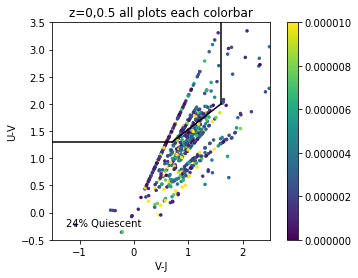

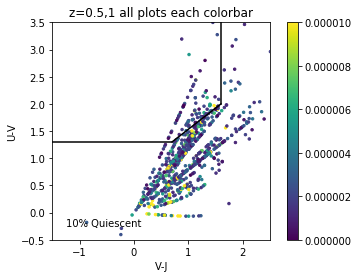

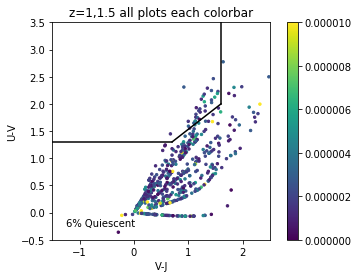

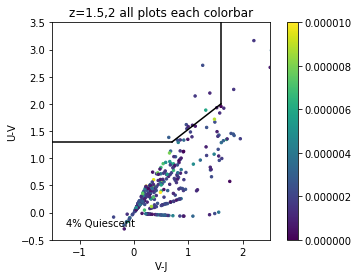

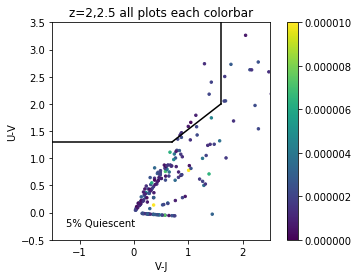

In [25]:
all_outliers = [] 
#doing a plot for each range of redshift 
for x in [[0,0.5,0.1], [0.5,1,0.1], [1,1.5,0.1], [1.5,2,1], [2,2.5,0.2]]:
    inds = np.where(np.logical_and(redshift > x[0], redshift < x[1]))
    xray1 = Xhard[inds[0]]
    ids1 = ids[inds[0]]
    
    U_V = U-V
    V_J = V-J
    U_V = U_V[inds[0]]
    V_J = V_J[inds[0]]
    
    #removing nans where U V or J didn't exist 
    non_nan_inds = np.where(np.logical_and(np.isnan(U_V) == False , np.isnan(V_J) == False))[0]
    U_V = U_V[non_nan_inds]
    V_J = V_J[non_nan_inds]
    xray1 = xray1[non_nan_inds]
    ids1 = ids1[non_nan_inds]
    
    #this is where we keep track of which sources are above the quiescent line 
    quiescent = [] 
    
    #defining quiescent sections numerically 
    first_section_V_J = np.where(np.logical_and(V_J > -6, V_J < 0.7))[0]
    first_section = np.where(U_V[first_section_V_J] > 1.3)[0]
    for fs in first_section: 
        quiescent.append(fs)
    
    second_section_V_J = np.where(np.logical_and(V_J > 0.7, V_J < 1.6))[0]
    for ss in second_section_V_J: 
        threshold = 0.7*(V_J[ss]-0.7)/0.9 + 1.3
        if U_V[ss] > threshold: 
            quiescent.append(ss)
    quiescent = np.array(quiescent) 
    
    #finding outliers on plot 
    V_J_outliers = np.where(np.logical_or(V_J > -1, V_J < 1))[0]
    U_V_outliers = np.where(np.logical_or(U_V > 2.5, U_V < -100))[0]

    all_outliers.append(ids1[U_V_outliers]) 
    all_outliers.append(ids1[V_J_outliers])

    plt.clf()
    ax = plt.axes()
    cmap_reversed = plt.cm.get_cmap('ocean_r')
    xb = int((max(V_J) - min(V_J))*4)
    yb = int((max(U_V) - min(U_V))*4)
    
    plt.scatter(V_J, U_V, c=xray1,s=6)
    #print(min(xray1[np.isnan(xray1) == False]))
    #print(max(xray1[np.isnan(xray1) == False]))
    plt.clim(0, .00001)
    plt.colorbar()
    
    plt.xlabel('V-J')
    plt.ylabel('U-V')
    
    plt.plot([-6,0.7],[1.3,1.3],'k')
    plt.plot([0.7,1.6],[1.3,2],'k')
    plt.plot([1.6,1.6],[2,6],'k')
    plt.xlim(-1.5,2.5)
    plt.ylim(-0.5,3.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('z=' + str(x[0]) + ',' + str(x[1]) + ' all plots each colorbar')
    plt.text(-1.25,-.25,str(int(len(quiescent)*100/len(U_V))) + '% Quiescent',color='black')
    plt.savefig('latest norm' + (str(x)) + '.png')
    plt.show()

In [26]:
#open plot for each outlier
for x in np.concatenate(all_outliers):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread("C:/Users/19133/Documents/Research/my fits/" + str(int(x)) + ".png")
    imgplot = plt.imshow(img)
    print(x)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/19133/Documents/Research/my fits/1497.png'